In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_pickle('../data/out/data.pkl')
df['year'] = df.date.dt.year.astype('Int64')

In [3]:
# Years with less than 100 movies
year_movie_count = df.year.value_counts()
year_movie_count[year_movie_count < 100].sort_index()

1893     1
1894     2
1895     9
1896     6
1897     4
1898     7
1899     1
1900     6
1901     2
1902     3
1903     4
1904     1
1905     3
1906     1
1907     8
1908     6
1909     5
1910    12
1911    42
1912    32
1913    37
1914    50
1915    50
1916    60
1917    44
1918    53
1919    48
1920    53
1921    60
1922    55
1923    58
1924    84
1925    90
1926    77
1927    95
2013    70
2014     4
Name: year, dtype: Int64

The tf-idf with sublinear tf scaling for a term $t$ of a document $d$ is given by

$$\text{tf-idf}(t, d) = (1 + \log\text{tf}(t, d)) \cdot \left(\log\frac{1 + n}{\text{1 + df}(t)} + 1\right)$$

where $n$ is the total number of documents and $\text{df}(t)$ is the document frequency of $t$ ([source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)).

We use sublinear tf scaling to reduce the significance of very common terms which are likely uninformative.

Here, a term is a phrase and a document is a year. Given a tf-idf vector for each year, we then normalize each tf-idf vector to have a Euclidean norm of 1.

In [4]:
phrases_by_year = df.query('1928 <= date.dt.year <= 2012').groupby('year').phrases.agg(lambda x: sum(x, []))
phrase_counts = pd.DataFrame(phrases_by_year.apply(Counter).tolist(), index=phrases_by_year.index).fillna(0).sort_index(1)
phrase_counts = phrase_counts.loc[:, phrase_counts.sum().ge(10)]
phrases_tfidf = pd.DataFrame(TfidfTransformer(sublinear_tf=True).fit_transform(phrase_counts).toarray(), index=phrase_counts.index, columns=phrase_counts.columns)

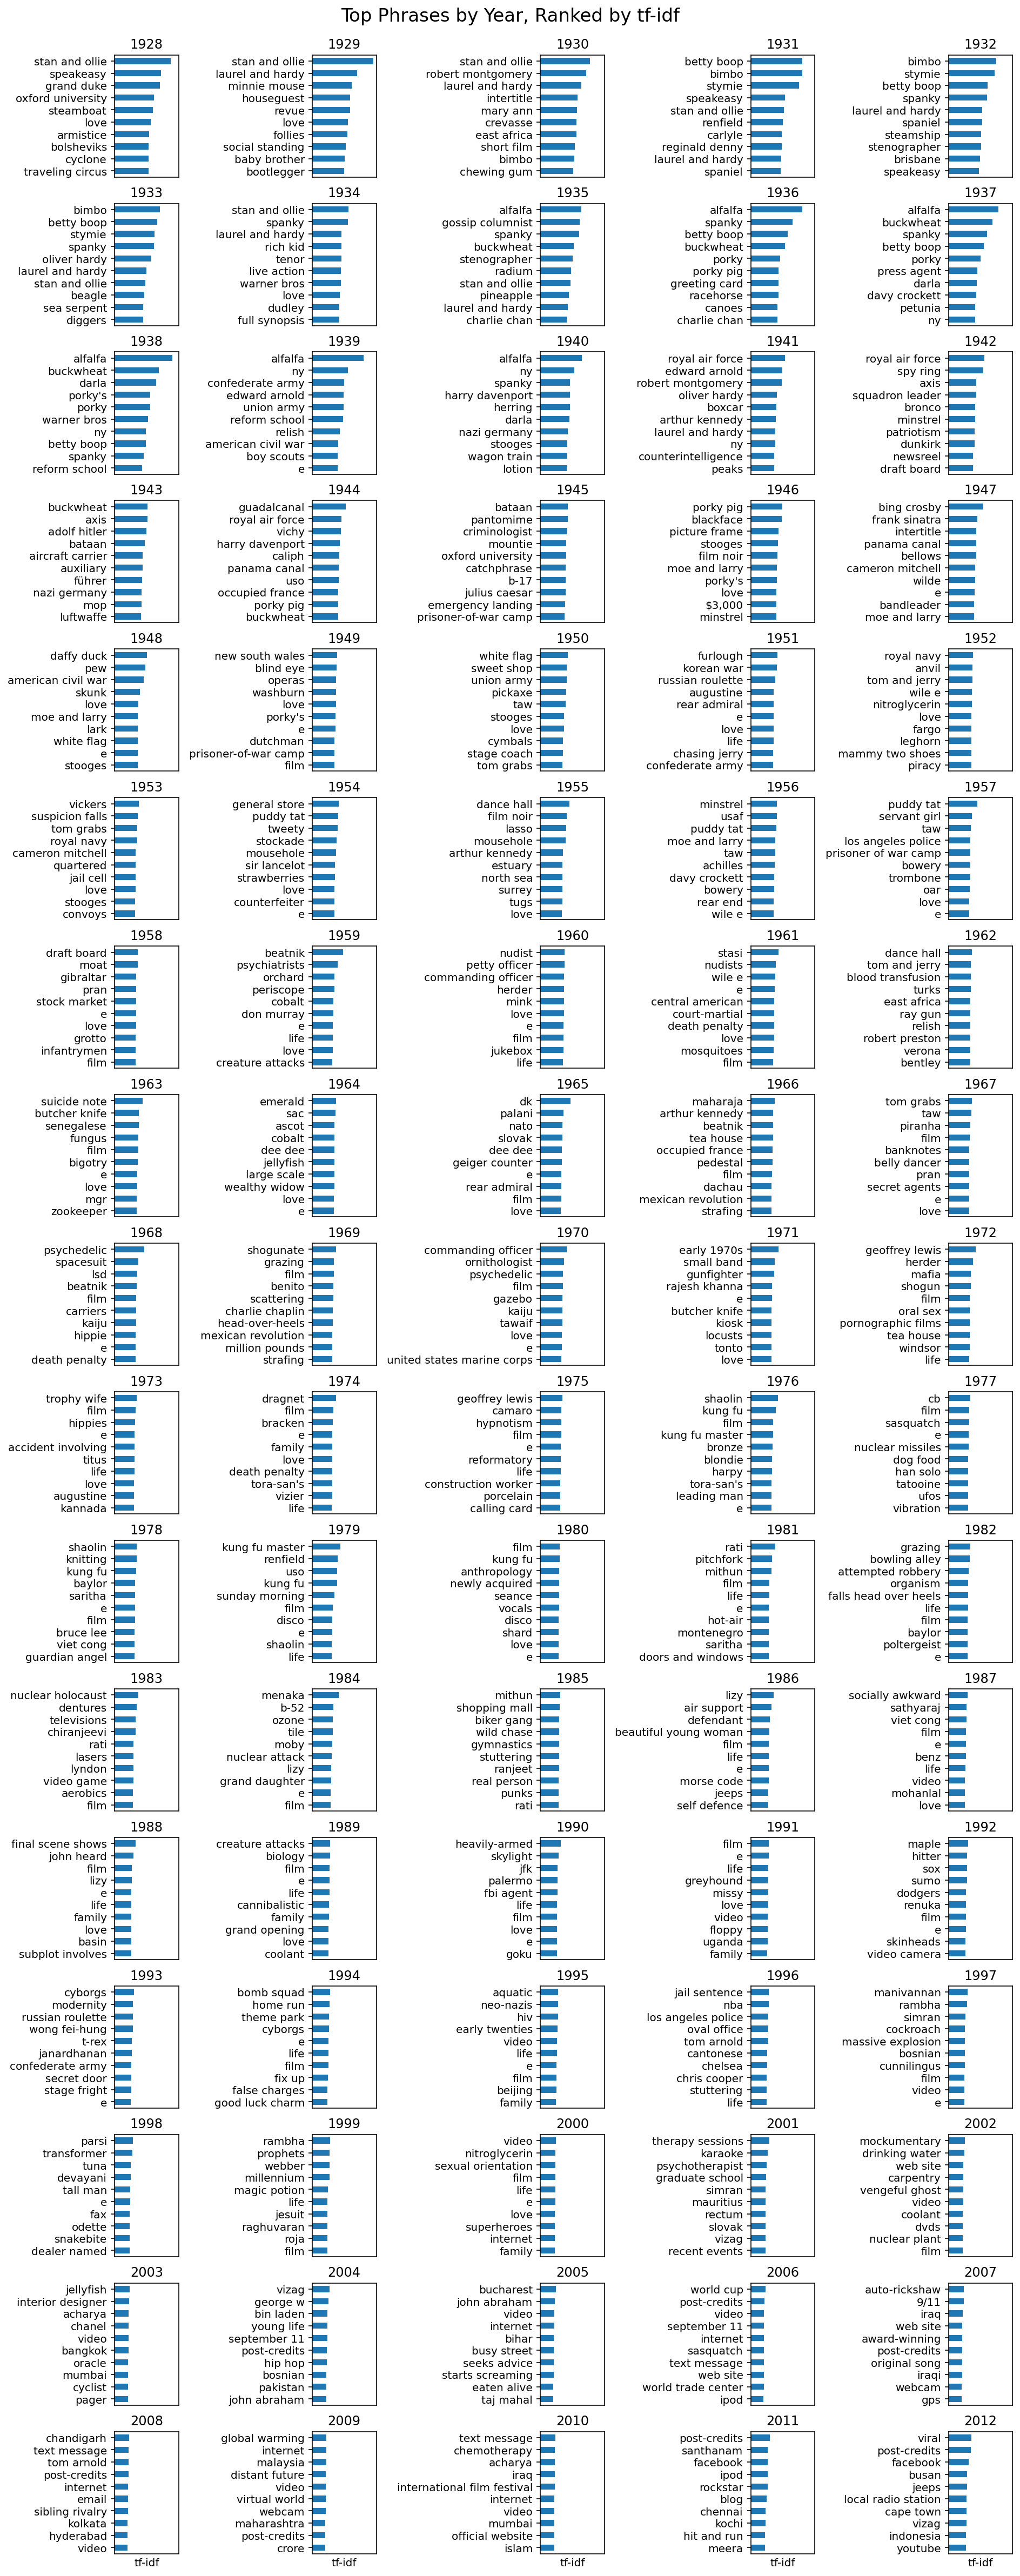

In [5]:
fig, axes = plt.subplots(-(-len(phrases_tfidf) // 5), 5, sharex=True, figsize=(13, 33), constrained_layout=True)
fig.suptitle('Top Phrases by Year, Ranked by tf-idf', size=17)
for year, ax in zip(phrases_tfidf.index, axes.flatten()):
    phrases_tfidf.loc[year].nlargest(10)[::-1].plot.barh(ax=ax)
    ax.set(title=year, xlabel='tf-idf')
    ax.tick_params(bottom=False, labelbottom=False)